# Depth Map Prediction from a Single Image using Multi-Scale Deep Network
## Implementation in tensorflow 2.0

## Steps:
1. Pull and load dataset
2. Process dataset into train and test sets
3. Build coarse and fine models
4. Train coarse model
5. Fix coarse model and train fine model
6. Evaluate performance metrics on test set

## Step1: Dataset Processing
Since this isn't within the scope of the project, it is just here for reference. I implemented a simpler data import for the KITTI dataset.
<img src="dataset_comp_graph.PNG" />

In [705]:
from __future__ import absolute_import, division, print_function
import os
from skimage.transform import downscale_local_mean, resize
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

In [361]:
tf.keras.backend.clear_session()
from tensorflow.keras import layers

## Importing Data & Pre-processing
This section was beyond the scope of the project. I added it to test the model. It is not the same as in the paper.

In this section, I:
1. Create a masking function to mask where distance values were not recorded. This mask is also used to evaluate the loss func.
2. Load images, depth maps, and create masks from the Kitti dataset. I downsampled the images by 2 and split them in two because the resulting networks were too large for my laptops memory otherwise.
3. Create a function for visualizing the data set
4. Split the dataset into training and validation sets. I skipped creating a test set.
5. Create tf.data.Datasets from the rgb images, depth maps, and masks for both training and validation
6. Shuffle the training data and create batches of size 32 (same as the paper)

In [733]:
def mask_zeros(img):
    """Creates a mask for depth maps where depth values were not recorded.
    
    Goes through the entire image to find locations/cells that record zero distance.
    These locations are recorded as 0s in the mask. If a location has a positive value,
    it is recorded as a 1 in the mask.
    
    Args:
        img: a ndarray recording of a depth map with shape (n_H, n_W).
        
    Returns:
        mask: a ndarray of zeros and ones with shape (n_H, n_W)
            recording where distance values were recorded.
    """
    mask = np.zeros((img.shape[0], img.shape[1]))
    for i, row in enumerate(img):
        for j, col in enumerate(row):
            if col > 0:
                mask[i, j] = 1
    return mask

In [734]:
def load_kitti_pairs(drive_date, drive, split_img=False, downscale=None):
    """Loads RGB images, depth maps, and creates masks from the KITTI dataset.
    
    First, finds all of the files for the rgb images and depth maps. Then, reads the image files
    into ndarrays, adds them to the list of images, and creates masks for the depth images.
    
    Args:
        drive_date: A String corresponding to the date of the drive (specific to KITTI dataset).
        drive: A String corresponding to the drive number.
        split_img: A Boolean. If True, this crops images in half (allows training on my computer due to memory).
        downscale: An Int. If provided, downsamples images by the given interger factor using the local mean.
        
    Returns:
        inputs: A ndarray of RGB images after transformations
        labels: A ndarray of depth maps corresponding to the RGB images
        masks: A ndarray of masks corresponding to the depth maps. See mask_zeros.    
    """
    common_path = str(drive_date) + "_drive_" + str(drive) + "_sync"
    ground_truth_loc = "kitti/depth/" + common_path + "/proj_depth/groundtruth/image_02"
    input_loc = "kitti/inputs/" + common_path + "/" + str(drive_date) + "/" + common_path + "/image_02/data"
    ground_truth_list = os.listdir(ground_truth_loc)
    inputs = []
    labels = []
    masks = []
    for ground_truth_fname in ground_truth_list:
        gt_image = plt.imread(ground_truth_loc + "/" + ground_truth_fname)
        in_image = plt.imread(input_loc + "/" + ground_truth_fname)
        if downscale:
            gt_image = downscale_local_mean(gt_image, (downscale, downscale))
            in_image = downscale_local_mean(in_image, (downscale, downscale, 1))
        if split_img:
            split_index = math.floor(gt_image.shape[1]/2)
            inputs.append(in_image[:,:split_index,:])
            inputs.append(in_image[:,split_index:split_index*2,:])
            labels.append(gt_image[:,:split_index])
            labels.append(gt_image[:,split_index:split_index*2])
            masks.append(mask_zeros(gt_image[:,:split_index]))
            masks.append(mask_zeros(gt_image[:,split_index:split_index*2]))
        else:
            inputs.append(in_image)
            labels.append(gt_image)
            masks.append(mask_zeros(gt_image))
    
    inputs = np.asarray(inputs)
    labels = np.asarray(labels)
    masks = np.asarray(masks)
        
    return inputs, labels, masks

In [735]:
inputs_2011_09_26_drive_0001, labels_2011_09_26_drive_0001, masks_2011_09_26_drive_0001 = load_kitti_pairs("2011_09_26", "0001", split_img = True, downscale=2)

In [736]:
def image_set_display(image_num, rgbs, labels, masks, figsize,
                      scale_depth=True, inverse=True, cmap=None):
    """Creates an image grid of RGBs, depth maps, and masks to understand the dataset.
    
    Args:
        image_num: An Int selecting the image number from the set of provided images.
        rgbs: An ndarray of rgb images.
        labels: An ndarray of depth maps.
        masks: An ndarray of masks.
        figsize: A tuple setting the size of the pyplot figure.
        scale_depth: A Boolean. If True, scales the left and right depth maps to [0, 1].
        inverse: A Boolean. If True, takes the inverse of the depth map. This allows closer values
            to appear brighter creating a more visually appealing display.
        cmap: A color map for displaying the depth map. See matplotlib.pyplot.imshow for details.    
    """
    l_img_num = image_num - image_num % 2
    r_img_num = l_img_num + 1
    
    rgb_l = rgbs[l_img_num]
    rgb_r = rgbs[r_img_num]
    label_l = labels[l_img_num]
    label_r = labels[r_img_num]
    mask_l = masks[l_img_num]
    mask_r = masks[r_img_num]
    
    if scale_depth:
        max_l = np.amax(label_l)
        max_r = np.amax(label_r)
        total_max = max(max_l, max_r)
        label_l = label_l/total_max
        label_r = label_r/total_max
    
    if inverse:
        label_l = (1-label_l)*mask_l
        label_r = (1-label_r)*mask_r
        
    img_arr = [rgb_l, rgb_r, label_l, label_r, mask_l, mask_r]
    fig = plt.figure(figsize = figsize)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(3, 2),
                     axes_pad=0.1,
                     )
    for count, (ax, img) in enumerate(zip(grid, img_arr)):
        if count < 2:
            ax.imshow(img)
        elif count < 4:
            ax.imshow(img, cmap = cmap)
        else:
            ax.imshow(img, cmap = "gray")
        
    plt.show()   

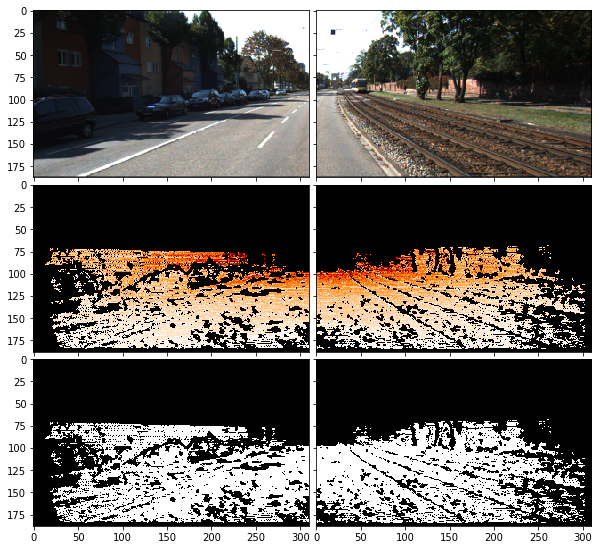

In [737]:
image_set_display(24,
                  inputs_2011_09_26_drive_0001,
                  labels_2011_09_26_drive_0001,
                  masks_2011_09_26_drive_0001,
                  (10, 10),
                  cmap="gist_heat")

In [738]:
TRAIN_VAL_RATIO = .85
total_images = len(inputs_2011_09_26_drive_0001)
train_split = math.floor(total_images*TRAIN_VAL_RATIO)
x_train = inputs_2011_09_26_drive_0001[:train_split]
y_train = labels_2011_09_26_drive_0001[:train_split]
m_train = masks_2011_09_26_drive_0001[:train_split]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,
                                                    y_train,
                                                    m_train))

x_val = inputs_2011_09_26_drive_0001[train_split:]
y_val = labels_2011_09_26_drive_0001[train_split:]
m_val = masks_2011_09_26_drive_0001[train_split:]

print("Total Images: " + str(total_images) + ", Training Images: "
      + str(len(x_train)) + ", Validation Images: " + str(len(x_val)))

Total Images: 196, Training Images: 166, Validation Images: 30


In [739]:
batch_size = 32
train_dataset_batched = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
train_dataset = (tf.convert_to_tensor(x_train, dtype=tf.float32),
                 tf.convert_to_tensor(y_train, dtype=tf.float32),
                 tf.convert_to_tensor(m_train, dtype=tf.float32))
val_dataset = (tf.convert_to_tensor(x_val, dtype=tf.float32),
               tf.convert_to_tensor(y_val, dtype=tf.float32),
               tf.convert_to_tensor(m_val, dtype=tf.float32))

## Model Definition
First, I will build the coarse model and then I will build the fine model as layers

Then, I will define the model as the composition of the two layers where I can allow the coarse model to be trained first and fixed

### coarse model:
The coarse model examines global features in the image. This layer consists of 5 convolutional layers followed by two fully connected layers
1. 11x11 conv, stride: 4, 2x2 pool, 96 channels
2. 5x5 conv, 2x2 pool, 256 channels
3. 3x3 conv, padding: same, 384 channels
4. 3x3 conv, padding: same, 384 channels
5. 3x3 conv, padding: same, 256 channels
6. FC: 4096 units
7. FC w/ linear dropout: output dim. = $(\Bigl\lfloor\dfrac{n_H-9}{2}+1\Bigr\rfloor\div 2, \quad\Bigl\lfloor\dfrac{n_W-9}{2}+1\Bigr\rfloor\div 2,\quad 1)$

*Note*: The final output predicts log depth

In [740]:
class CoarseNet(tf.keras.Model):
    """Takes raw image input and converts it to a coarse depth map based on global features.
    
    This represents layers Course 1 through Course 7 in the paper. The coarse model has
    5 convolutional layers followed by two fully connected layers. The fully connected
    layers at the top of the network allow identifying features accross the entire image
    creating the global view of the network.
    
    Attributes:
            rate: A float that sets the dropout rate. Note that since TensorFlow 2.0, this
                represents the fraction of the input units to drop.
            verbose: A boolean. If True, the model will print out the shape of outputs from
                each of the layers
            name: A String that sets the name of the model. It is also used in the individual
                names of the layers. These names are used in the training loop and are hardcoded.
                If the name attribute is changed from the default, make sure to change the
                corresponding value in the training loop.
                
    """
    
    def __init__(self,
                 rate=0.2,
                 verbose=False,
                 name="Coarse"):
        """Inits CoarseNet with the dropout rate, whether to print layer shapes, and the name of the network.
        
        Since most of the layers are convolutional layers that don't depend on the shape of the inputs for
        initialization, they can be initialized here.
        """
        super(CoarseNet, self).__init__(name=name)
        self.drop_rate = rate
        self.verbose = verbose
        self.conv1 = layers.Conv2D(96, (11, 11), strides=(4,4), padding="valid", activation="relu", name=name + str(1))
        self.pool1 = layers.MaxPool2D()
        self.conv2 = layers.Conv2D(256, (5, 5), padding="same", activation="relu", name=name + str(2))
        self.pool2 = layers.MaxPool2D()
        self.conv3 = layers.Conv2D(384, (3, 3), padding="same", activation="relu", name=name + str(3))
        self.conv4 = layers.Conv2D(384, (3, 3), padding="same", activation="relu", name=name + str(4))
        self.conv5 = layers.Conv2D(256, (3, 3), strides=(2,2), padding="valid", activation="relu", name=name + str(5))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(4096, activation="relu", name=name + str(6))
        self.dropout = layers.Dropout(self.drop_rate)
    
    def build(self, input_shape):
        """Initializes the final dense layer whose output dimension depends on the input shape.
        
        The build method is used to calculate the final shape of the coarse model output to fit with Fine 1
        of the fine network. Note: The publication seems to have the wrong value for the width of the output
        on the KITTI dataset. It's listed as 27 and should be 41.
        
        Args:
            input_shape: Inputs to the network have shape (batches, n_H, n_W, channels).
        """
        n_H_out = int(math.floor((input_shape[1]-9)/2 + 1)/2)
        n_W_out = int(math.floor((input_shape[2]-9)/2 + 1)/2)
        n_total = n_W_out*n_H_out
        self.dense2 = layers.Dense(n_total, name=self.name + str(7))
        self.reshape = layers.Reshape((n_H_out, n_W_out))
        
    def call(self, inputs, training=None):
        """This method executes each of the layers whenever the model is run.
        
        The call method takes the inputs and sequentially passes them through each layer of the
        Coarse model architecture. The dropout layer is only used during training. It is skipped
        during inference.
        
        Args:
            inputs: A tensor with shape (batches, n_H, n_W, channels).
            training: A boolean. If true, dropout will be included before the final dense layer.
            
        Returns:
            coarse_7: A tensor with shape (batches, n_H_out, n_W_out) where n_H_out
                and n_W_out correspond the the shape of Fine 1 in the fine model.
        """
        x = self.conv1(inputs)
        coarse_1 = self.pool1(x)
        x = self.conv2(coarse_1)
        coarse_2 = self.pool2(x)
        coarse_3 = self.conv3(coarse_2)
        coarse_4 = self.conv4(coarse_3)
        coarse_5 = self.conv5(coarse_4)
        x = self.flatten(coarse_5)
        coarse_6 = self.dense1(x)
        if training:
            x = self.dropout(coarse_6)
        else:
            x = coarse_6
            build_d = self.dropout(coarse_6)
        x = self.dense2(x)
        coarse_7 = self.reshape(x)
        
        if(self.verbose):
            print("Layer shapes:\nCoarse 1: " + str(coarse_1.shape) + "\nCoarse 2: " + str(coarse_2.shape) + ", Coarse 3: " +
                  str(coarse_3.shape) + ", Coarse 4: " + str(coarse_4.shape) + "\nCoarse 5: " + str(coarse_5.shape) +
                  "\nCoarse 6: " + str(coarse_6.shape) + "\nCoarse 7: " + str(coarse_7.shape))
        
        return coarse_7      


In [741]:
test_tensor = tf.random.uniform(shape=(32, 304, 228, 3))
coarse_test = CoarseNet(name="coarse_test", verbose=False)
coarse_out_test = coarse_test(test_tensor)

In [742]:
coarse_test.summary()

Model: "coarse_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
coarse_test1 (Conv2D)        multiple                  34944     
_________________________________________________________________
max_pooling2d_71 (MaxPooling multiple                  0         
_________________________________________________________________
coarse_test2 (Conv2D)        multiple                  614656    
_________________________________________________________________
max_pooling2d_72 (MaxPooling multiple                  0         
_________________________________________________________________
coarse_test3 (Conv2D)        multiple                  885120    
_________________________________________________________________
coarse_test4 (Conv2D)        multiple                  1327488   
_________________________________________________________________
coarse_test5 (Conv2D)        multiple                  

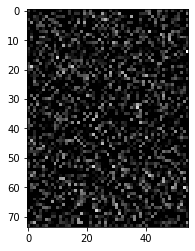

In [743]:
coarse_out_test1 = np.clip(coarse_out_test[1].numpy(), 0, 1)
img = plt.imshow(coarse_out_test1, cmap='gray')

### fine model:
The fine model is designed to analyze local features in the image. The fine model consists of 3 convolutional layers and 1 concatenation layer:

1. 9x9 conv, padding: same, stride: 2, 2x2 pool, 63 channels
2. Concatenate output of the coarse model with the output of step 1
3. 5x5 conv, padding: same, 64 channels
4. 5x5 conv, padding: same, 1 channel (The final output predicts log depth)

In [744]:
class FineNet(tf.keras.Model):
    """Takes raw image input and converts it to a coarse depth map based on fine + global features.
    
    This network is focused on incorporating fine features into the depth map prediction. It uses
    three convolutional layers for this. Additionally, it incorporates a global perspective by
    concatenating the output of the Course Model into the output of Fine 1.
    
    Attributes:
        name: A String that sets the name of the model. This is used to name the individual layers
            and is used in the training loop. If the name is changed from the default value, the names
            need to be changed in the training loop. They are hard coded in the training loop for
            assigning layer-wise learning rates
    """
    
    def __init__(self,
                 name="Fine"):
        """Inits FineNet with the name of the model."""
        super(FineNet, self).__init__(name=name)
        self.conv1 = layers.Conv2D(63, (9, 9), strides=(2,2), padding="valid", activation="relu", name = name + str(1))
        self.pool1 = layers.MaxPool2D()
        self.conc = layers.Concatenate()
        self.conv2 = layers.Conv2D(64, (5, 5), padding="same", activation="relu", name=name + str(3))
        self.conv3 = layers.Conv2D(1, (5, 5), padding="same", activation="linear", name=name + str(4))
        
    def build(self, input_shape):
        """Initializes the reshape layer for changing the shape of the outpute from the Coarse Model.
        
        The coarse model output is of shape (batches, n_H_coarse, n_W_coarse). To be concatenated with
        the Fine 1, it needs to be of shape (batches, n_H_coarse, n_W_coarse, 1).
        
        Args:
            input_shape: A dict with keys "orig" and "coarse". input_shape["coarse"] contains the dimensions
                of the coarse model output and has shape (batches, n_H_coarse, n_W_coarse).
        """
        coarse_shape = input_shape['coarse']
        n_H_coarse = coarse_shape[1]
        n_W_coarse = coarse_shape[2]
        self.reshape = layers.Reshape((n_H_coarse, n_W_coarse, 1))
        
        
    def call(self, inputs):
        """This method executes each of the layers whenever the model is run.
        
        The call method takes the inputs and sequentially passes them through each layer of the
        Fine model architecture to create a depth map based on fine and global features.
        
        Args:
            inputs: A dict with keys "orig" and "coarse". inputs["orig"] is a tensor of shape
                (batches, n_H, n_W, channels). inputs["coarse"] is a tensor of shape
                (batches, n_H_coarse, n_W_coarse).
            
        Returns:
            fine_4: A tensor with shape (batches, n_H_out, n_W_out, 1) where n_H_out
                and n_W_out are the dimensions of the output depth map from the network.
        """
        orig_input = inputs["orig"]
        coarse_input = inputs["coarse"]
        x = self.conv1(orig_input)
        fine_1 = self.pool1(x)
        coarse_input = self.reshape(coarse_input)
        fine_2 = self.conc([fine_1, coarse_input])
        fine_3 = self.conv2(fine_2)
        fine_4 = self.conv3(fine_3)
        
        return fine_4

In [745]:
def combined_model(input_image, coarse_model, fine_model,
                   training_coarse=False, training_fine=False):
    """Combines the coarse and fine models together.
    
    Args:
        input_image: A tensor of shape (batches, n_H, n_W, 3).
        coarse_model: A keras Model that implements the coarse model architecture.
        fine_model: A keras Model that implements the fine model architecture.
        training_coarse: A boolean. If True, sets training equal to True in the Coarse Model.
            This will have the effect of implementing dropout before the final dense layer.
        training_fine: A boolean. If True, sets training equal to True in the Fine Model. Currently,
            this will have no effect but could be used if something like dropout were added to the fine
            model in the future.
            
    Returns:
        y_pred: A tensor representing the predicted depth map. It has shape (batches, n_H_out, n_W_out, 1)
    """
    coarse_out = coarse_model(input_image, training = training_coarse)
    fine_in = {
        "orig": input_image,
        "coarse": coarse_out,
    }
    y_pred = fine_model(fine_in, training = training_fine)
    
    return y_pred

In [746]:
fine_test = FineNet(name="fine")
y_pred_test = combined_model(test_tensor, coarse_test, fine_test)

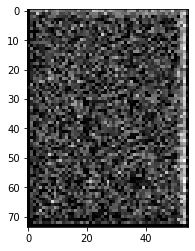

In [747]:
refined_image = y_pred_test.numpy()
refined_shape = refined_image.shape
refined_image = refined_image.reshape((refined_shape[0], refined_shape[1], refined_shape[2]))
refined_image1_clipped = np.clip(refined_image[1], 0, 1)
img = plt.imshow(refined_image1_clipped, cmap='gray')

In [748]:
fine_test.summary()

Model: "fine"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fine1 (Conv2D)               multiple                  15372     
_________________________________________________________________
max_pooling2d_73 (MaxPooling multiple                  0         
_________________________________________________________________
concatenate_33 (Concatenate) multiple                  0         
_________________________________________________________________
fine3 (Conv2D)               multiple                  102464    
_________________________________________________________________
fine4 (Conv2D)               multiple                  1601      
_________________________________________________________________
reshape_11238 (Reshape)      multiple                  0         
Total params: 119,437
Trainable params: 119,437
Non-trainable params: 0
________________________________________________________

## Model Training

In [617]:
coarse_model = CoarseNet(name="Coarse")

In [663]:
fine_model = FineNet(name="Fine")

### Scale Invariant Loss Function
The paper used a scale invariant loss that is a version of MSE where the errors are based on the difference of differences. The specific loss function is:

L(y, y*) = $\dfrac{1}{n}\sum_{i} d_i^{2} - \dfrac{\lambda}{n^{2}}\left( \sum_{i} d_i \right)^{2}$, where n is the sum of 1s in the mask, $\lambda$ is a hyper-parameter that balances between elementwise $l_2$ loss and the scale-invariant error, and $d_i = log(y_i) - log(y_{i}*)$

In [620]:
def scale_invariant_MSE(y_true, y_pred, mask):
    """This calculates the scale invariant error given ground truths, predictions, and masks.
    
    This function implements the scale invariant MSE defined in Eigen et. al. it is essentially
    the sum of the squared difference between all of the distances of the ground truth values
    and the distances of all of the corresponding prediction values. Because it is the difference
    of differences, it is invariant to the mean of the ground truths and predictions. Eigen et al.
    chose a scale invariant error because they noticed that a change in the mean log depth
    impacted the RMSE to a large degree. With this loss function, chaning the scale does not
    change the error.
    
    Both n_H_pred and n_W_pred, the outputs of the fine model, are smaller than n_H and n_W, respectively.
    Because of the difference in the size of the tensors, to compare them, y_pred is resized to be the
    same size as y_true.
    
    The mask is used so that errors where the depth map didn't have a reading are not counted into
    the loss function.
    
    Args:
        y_true: A tensor representing the ground truth depths. It has shape (batches, n_H, n_W).
        y_pred: A tensor representing the predicted depths. It has shape (batches, n_H_pred, n_W_pred, 1).
        mask: A tensor masking the parts of loss where y_true didn't have a reading.
            It has shape (batches, n_H, n_W)
            
    Returns:
        batch_loss: the sum of scale invariant losses for the batch divided by the number of samples in
            the batch.
    """
    n_H = y_true.shape[1]
    n_W = y_true.shape[2]
    n_H_pred = y_pred.shape[1]
    n_W_pred = y_pred.shape[2]
    y_true = layers.Reshape((n_H, n_W, 1))(y_true)
    y_pred = layers.Reshape((n_H_pred, n_W_pred, 1))(y_pred)
    
    log_pred = tf.image.resize(y_pred, (n_H, n_W), method="nearest")
    log_true = tf.math.log(y_true + 1e-30) #adding 1e-30 prevents -inf
    mask = tf.dtypes.cast(mask, tf.float32)
    mask = layers.Reshape((n_H, n_W, 1))(mask)
    log_pred = log_pred*mask
    log_true = log_true*mask
        
    d = tf.math.subtract(log_true, log_pred)
    n = tf.math.reduce_sum(mask, [1, 2, 3])
    d2 = d**2
    D_sum1 = tf.math.reduce_sum(d2, [1, 2, 3])
    D_sum2 = tf.math.reduce_sum(d, [1, 2, 3])**2
    lamb = 0.5
    D = (1./n)*D_sum1 - (lamb/(n*n))*D_sum2
    batch_loss = tf.math.reduce_sum(D)
    batch_loss = batch_loss/D.shape[0]
    
    return batch_loss
    

### Training Loop for Coarse Model
I use a custom training loop here with gradient tape because it is the most straightforward way to implement layer dependent learning rates with SGD. Training with layer dependent learning rates, as in the paper, did result in lower losses compared to constant rate learning.

In [649]:
def train_coarse(model, train_dataset_batched, train_dataset, val_dataset, epochs,
                 lr12345=0.001, lr67=0.1):
    """This is the training loop for the coarse model.
    
    This training loop uses layer-wise training rates to train the course model. Specifically,
    layers 1 through 5 have a default training rate of 0.001 while layers 6 and 7 have a default
    training rate of 0.1. These default values do have better training performance than when using
    a constant training rate.
    
    Note: The layer-wise learning rates depend on the layer names. These are based on the default
    values set in the CoarseNet and FineNet classes.
    
    Args:
        model: A keras Model that defines the coarse model.
        train_dataset_batched: A tf.data.Dataset that contains batched training data with tensors
            of shape (batches, n_H, n_W, channels).
        train_dataset: A tensor containing the entire training dataset with shape
            (training_size, n_H, n_W, channels). This is used for calculating the overall training set
            loss after each epoch.
        val_dataset: A tensor containing the entire validation dataset with shape
            (validation_size, n_H, n_W, channels). This is used for calculating the overall validation set
            loss after each epoch.
        epochs:
            An int that sets how many times the training loop should itterate through all of the data.
        lr12345: A float that sets the learning rate for layers 1 through 5.
        lr67: A float that sets the learning rate for layers 6 through 7.
        
    Returns:
        train_losses: A list of the training losses after each epoch
        val_losses: A list of the validation losses after each epoch
    """
    train_losses = []
    val_losses = []
    
    optimizer_c12345 = tf.keras.optimizers.SGD(learning_rate=lr12345, momentum=0.9,
                                               nesterov=False, name='SGD1')
    optimizer_c67 = tf.keras.optimizers.SGD(learning_rate=lr67, momentum=0.9,
                                            nesterov=False, name='SGD2')
    
    for epoch in range(epochs):        
        for step, (x_batch_train, y_batch_train, m_batch_train) in enumerate(train_dataset_batched):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch_train, training=True)
                
                loss_value = scale_invariant_MSE(y_batch_train, y_pred, m_batch_train)
                
            grads = tape.gradient(loss_value, model.trainable_weights)
            
            trainable_weights = model.trainable_weights            
            coarse12345_weights = []
            coarse12345_grads = []
            coarse67_weights = []
            coarse67_grads = []
            
            for i, weight in enumerate(trainable_weights):
                w_name = weight.name
                grad = grads[i]
                
                if("Coarse6" in w_name or "Coarse7" in w_name):
                    coarse67_weights.append(weight)
                    coarse67_grads.append(grad)
                else:
                    coarse12345_weights.append(weight)
                    coarse12345_grads.append(grad)
            
            optimizer_c12345.apply_gradients(zip(coarse12345_grads, coarse12345_weights))
            optimizer_c67.apply_gradients(zip(coarse67_grads, coarse67_weights))
            
        x_train, y_train, m_train = train_dataset
        y_pred_train = model(x_train, training=False)
        train_loss = scale_invariant_MSE(y_train, y_pred_train, m_train).numpy()
        train_losses.append(train_loss)
        
        x_val, y_val, m_val = val_dataset
        y_pred_val = model(x_val, training=False)
        val_loss = scale_invariant_MSE(y_val, y_pred_val, m_val).numpy()
        val_losses.append(val_loss)
        
        if epoch % 5 == 0:
            print("After epoch " + str(epoch) + ", Training Loss: "
                  + str(train_loss) + ", Validation Loss: " + str(val_loss))
            
    return train_losses, val_losses

In [622]:
train_losses, val_losses = train_coarse(coarse_model, train_dataset_batched, train_dataset, val_dataset, 100)

n_H: 188, n_W310
n_H_out: 45, n_W_out: 75
After epoch 0, Training Loss: 7.0627785, Validation Loss: 7.2870383
After epoch 5, Training Loss: 0.6632071, Validation Loss: 0.6709082
After epoch 10, Training Loss: 0.28246966, Validation Loss: 0.28204796
After epoch 15, Training Loss: 0.27583188, Validation Loss: 0.2487755
After epoch 20, Training Loss: 0.25445893, Validation Loss: 0.25022343
After epoch 25, Training Loss: 0.25345737, Validation Loss: 0.26025608
After epoch 30, Training Loss: 0.23734266, Validation Loss: 0.22800037
After epoch 35, Training Loss: 0.22602852, Validation Loss: 0.2237949
After epoch 40, Training Loss: 0.21596566, Validation Loss: 0.21985783
After epoch 45, Training Loss: 0.20940708, Validation Loss: 0.220555
After epoch 50, Training Loss: 0.20652975, Validation Loss: 0.222131
After epoch 55, Training Loss: 0.20573469, Validation Loss: 0.2174219
After epoch 60, Training Loss: 0.20347044, Validation Loss: 0.21660103
After epoch 65, Training Loss: 0.20239826, Valid

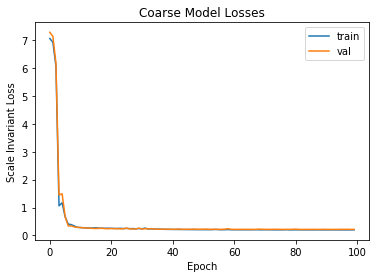

In [650]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Coarse Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Scale Invariant Loss")
plt.show()

In [720]:
input_test = tf.convert_to_tensor(inputs_2011_09_26_drive_0001)
out_test = coarse_model(input_test)

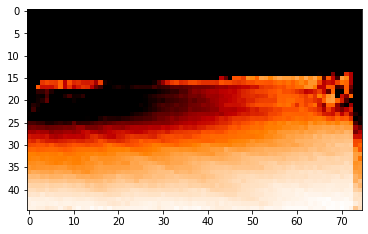

In [721]:
plt.imshow(1-np.clip(tf.math.exp(out_test[1]).numpy(), a_min=0, a_max = .1)/.1, cmap="gist_heat")

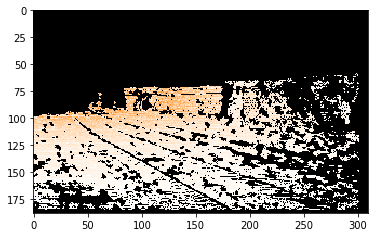

In [722]:
plt.imshow((1-labels_2011_09_26_drive_0001[1])*masks_2011_09_26_drive_0001[1], cmap="gist_heat")

### Training Loop for Fine Model

In [661]:
def train_fine(coarse_model, fine_model, train_dataset_batched, train_dataset, val_dataset, epochs,
               lr14 = 0.001, lr3 = 0.01):
    """This is the training loop for the fine model.
    
    The coarse model is fixed while the loop trains the fine model.
    
    This training loop uses layer-wise training rates to train the fine model. Specifically,
    layers 1 and 4 have a default training rate of 0.001 while layer 3 has a default training
    rate of 0.1.
    
    Note: The layer-wise learning rates depend on the layer names. These are based on the default
    values set in the CoarseNet and FineNet classes.
    
    Args:
        coarse_model: A keras Model that defines the coarse model.
        fine_model: A keras Model that defines the fine model.
        train_dataset_batched: A tf.data.Dataset that contains batched training data with tensors
            of shape (batches, n_H, n_W, channels).
        train_dataset: A tensor containing the entire training dataset with shape
            (training_size, n_H, n_W, channels). This is used for calculating the overall training set
            loss after each epoch.
        val_dataset: A tensor containing the entire validation dataset with shape
            (validation_size, n_H, n_W, channels). This is used for calculating the overall validation set
            loss after each epoch.
        epochs:
            An int that sets how many times the training loop should itterate through all of the data.
        lr14: A float that sets the learning rate for layers 1 and 4.
        lr3: A float that sets the learning rate for layer 3.
        
    Returns:
        train_losses: A list of the training losses after each epoch
        val_losses: A list of the validation losses after each epoch
    """
    train_losses = []
    val_losses = []
    
    optimizer_f14 = tf.keras.optimizers.SGD(learning_rate=lr14, momentum=0.9,
                                            nesterov=False, name='SGD3')
    optimizer_f3 = tf.keras.optimizers.SGD(learning_rate=lr3, momentum=0.9,
                                           nesterov=False, name='SGD4')
    
    for epoch in range(epochs):        
        for step, (x_batch_train, y_batch_train, m_batch_train) in enumerate(train_dataset_batched):
            with tf.GradientTape() as tape:
                
                y_pred = combined_model(x_batch_train, coarse_model, fine_model, training_fine=True)                
                loss_value = scale_invariant_MSE(y_batch_train, y_pred, m_batch_train)
                
            grads = tape.gradient(loss_value, fine_model.trainable_weights)
            
            trainable_weights = fine_model.trainable_weights            
            fine14_weights = []
            fine14_grads = []
            fine3_weights = []
            fine3_grads = []
            
            for i, weight in enumerate(trainable_weights):
                w_name = weight.name
                grad = grads[i]
                
                if("Fine3" in w_name):
                    fine3_weights.append(weight)
                    fine3_grads.append(grad)
                else:
                    fine14_weights.append(weight)
                    fine14_grads.append(grad)
            
            #the two layers below are where I implement layer-wise learning rates
            optimizer_f14.apply_gradients(zip(fine14_grads, fine14_weights))
            optimizer_f3.apply_gradients(zip(fine3_grads, fine3_weights))
            
        x_train, y_train, m_train = train_dataset
        y_pred_train = combined_model(x_train, coarse_model, fine_model)
        train_loss = scale_invariant_MSE(y_train, y_pred_train, m_train).numpy()
        train_losses.append(train_loss)
        
        x_val, y_val, m_val = val_dataset
        y_pred_val = combined_model(x_val, coarse_model, fine_model)
        val_loss = scale_invariant_MSE(y_val, y_pred_val, m_val).numpy()
        val_losses.append(val_loss)
        
        if epoch % 5 == 0:
            print("After epoch " + str(epoch) + ", Training Loss: "
                  + str(train_loss) + ", Validation Loss: " + str(val_loss))
            
    return train_losses, val_losses

In [664]:
train_fine_losses, val_fine_losses = train_fine(coarse_model, fine_model, train_dataset_batched, train_dataset, val_dataset, 100)

After epoch 0, Training Loss: 2.0561543, Validation Loss: 2.1008632
After epoch 5, Training Loss: 0.2713119, Validation Loss: 0.30083165
After epoch 10, Training Loss: 0.24231766, Validation Loss: 0.25834373
After epoch 15, Training Loss: 0.21989407, Validation Loss: 0.23720282
After epoch 20, Training Loss: 0.21248232, Validation Loss: 0.23364292
After epoch 25, Training Loss: 0.20772725, Validation Loss: 0.22775134
After epoch 30, Training Loss: 0.20489803, Validation Loss: 0.22391336
After epoch 35, Training Loss: 0.20640421, Validation Loss: 0.22765034
After epoch 40, Training Loss: 0.20246018, Validation Loss: 0.22016798
After epoch 45, Training Loss: 0.20180558, Validation Loss: 0.21977192
After epoch 50, Training Loss: 0.20371997, Validation Loss: 0.22464442
After epoch 55, Training Loss: 0.20087014, Validation Loss: 0.21889754
After epoch 60, Training Loss: 0.20060912, Validation Loss: 0.21911877
After epoch 65, Training Loss: 0.20076011, Validation Loss: 0.21732238
After epoch

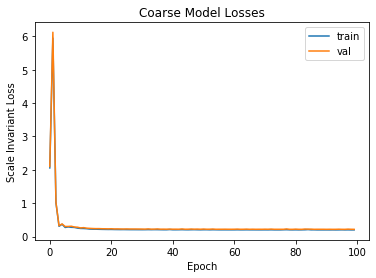

In [679]:
plt.plot(train_fine_losses, label="train")
plt.plot(val_fine_losses, label="val")
plt.legend()
plt.title("Coarse Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Scale Invariant Loss")
plt.show()

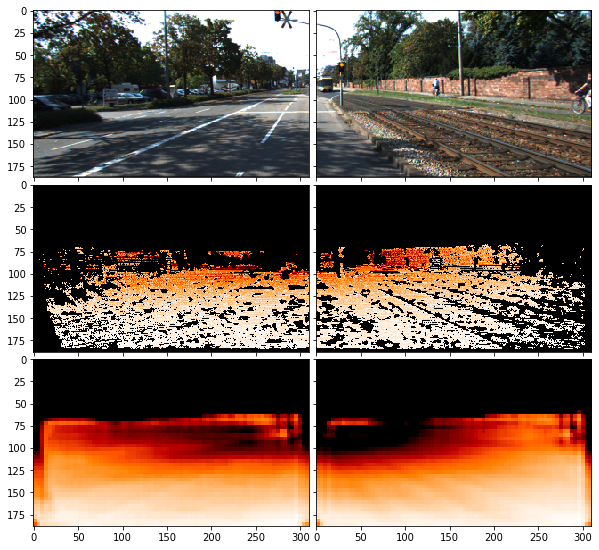

In [712]:
img_num = 180
rgbs = inputs_2011_09_26_drive_0001[img_num:img_num+2]
rgbs_shape = rgbs[0].shape

fine_out_test = combined_model(input_test, coarse_model, fine_model)
fine_out_test = tf.math.exp(fine_out_test[img_num:img_num+2])
fine_out_test = tf.image.resize(fine_out_test, (rgbs_shape[0], rgbs_shape[1]), method="nearest").numpy()
fine_out_test = fine_out_test.reshape((2, fine_out_test.shape[1], fine_out_test.shape[2]))
fine_out_test = 1-np.clip(fine_out_test, a_min=0, a_max = .1)/.1
labels = labels_2011_09_26_drive_0001[img_num:img_num+2]
labels_max = np.amax(labels)
masks = masks_2011_09_26_drive_0001[img_num:img_num+2]
labels = (1-labels/labels_max)*masks
imgs_result = [rgbs[0], rgbs[1], labels[0], labels[1], fine_out_test[0], fine_out_test[1]]
fig = plt.figure(figsize = (10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 2),
                 axes_pad=0.1,
                 )
for count, (ax, img) in enumerate(zip(grid, imgs_result)):
    if count < 2:
        ax.imshow(img)
    else:
        ax.imshow(img, cmap="gist_heat")

plt.show()  